# Rozpoznawanie udzielenia pożyczki przez bank (Bank Loan Classification)

## 1. Opis problemu

Celem projektu jest przewidzenie czy bank udzieli pożyczki w opraciu o dane osoby. Dane wykorzystywane do projektu pochodzą z serwisu Kaggle, można je znaleźć pod adresem https://www.kaggle.com/sriharipramod/bank-loan-classification. Zawierają one informacje o osobach, które ubiegały się o udzelenie pożyczki przez bank oraz decyzję banku. 

## 2. Podstawowa analiza zbioru danych

Analizowany zbiór danych posiada następujące atrybuty:

*  **id** - numer przydzielony osobie
*  **Age** - wiek osoby starającej się o pożyczkę
* **Experience** - czas posiadania konta bankowego przez osobę (w latach)
* **Income** - roczne przychody osoby (w tysiącach dolarów)
* **ZIP Code** - kod pocztowy osoby
* **Family** - liczba członków najbliższej rodziny osoby
* **CCAvg** - średnie miesięczne wydatki z karty kredytowej osoby (w tysiącach dolarów)
* **Education** - liczbowy wskaźnik edukacji osoby
* **Mortgage** - wysokość posiadanego kredytu hipotecznego (w tysiącach dolarów)
* **Personal Loan** - liczbowa reprezentacja informacji czy bank udzielił pożyczki (0 lub 1)
* **Securities Account** - liczbowa reprezentacja informacji czy osoba posiada 
* **CD Account** - liczbowa reprezentacja informacji czy osoba posiada certyfikat depozytowy (0 lub 1)
* **Online** - liczbowa reprezentacja informacji czy osoba posiada konto internetowe w banku (0 lub 1)
* **CreditCard** - iczbowa reprezentacja informacji czy osoba posiada kartę kredytową (0 lub 1)


### Przygotowanie środowiska
Pakiety które będą potrzebne do analizy zbioru:

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

from sklearn.naive_bayes import GaussianNB
from sklearn import tree

### Wczytanie zbioru danych

In [4]:
df_org = pd.read_csv("UniversalBank.csv") 

Orginalny zbiór danych będzie znajdował się w ramce danych "df_org".

### Podstawowe parametry danych
Po wczytaniu zbioru można sprawdzić czy nie występują w nim żadne braki:

In [5]:
liczbaBrakujacychElementow = df_org.isnull().sum().sum()
print(f"Liczba brakujących elementów: {liczbaBrakujacychElementow}")

Liczba brakujących elementów: 0


Analizowany zbiór danych nie zawiera żadnych pustych komórek w związku z czym nie trzeba usuwać żadnych wierszy lub kolumn. Następnie można zliczyć ilość obiektów oraz atrybutów je opisujących.

In [6]:
lObiektow = df_org.shape[0]
lAtrybutow = df_org.columns.size

print("Liczba obiektów: " + str(lObiektow))
print("Liczba atrybutów: " + str(lAtrybutow))
print("Jeden z atrybutów jest atrybutem decyzyjnym, zatem pozostaje 13 atrybutów do analizy")

Liczba obiektów: 5000
Liczba atrybutów: 14
Jeden z atrybutów jest atrybutem decyzyjnym, zatem pozostaje 13 atrybutów do analizy


Typ wczytanych danych prezentuje się następująco:

In [7]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Wszystkie dane są typu liczbowego - 13 atrybutów jest typu int64, jeden atrybut (CCAvg) jest typu float64. Ponieważ wszystkie dane są typu liczbowego to nie jest konieczna ich konwersja.

Wyświetlenie początku oraz końca ramki danych w celu lepszego zobrazowania: 

In [9]:
df_org.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [10]:
data.tail()

NameError: name 'data' is not defined

Jako, że atrybut 'Personal Loan' jest atrybutem decyzyjnym korzystnym dla późniejszej analizy będzie umieszczenie go jako ostatnią kolumnę ramki danych. Atrybuty 'ID' oraz 'ZIP Code' można usunąć z ramki danych, ponieważ są one nieistotne dla rozpatrywanego problemu przydzielania kredytu.

Następnie można zbadać podstawowe miary statystyczne zbioru danych:

In [11]:
df_org.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


Jak widać jedynie 9.6% osób otrzymuje spełnia warunki banku i otrzymuje pożyczkę.

#### Wnioski z podstawowej analizy zbioru danych: (TODO)
* Atrybuty 'ID' oraz 'ZIP Code' można usunąć z ramki danych.
* 

## 3. Przygotowanie zbioru do dalszej analizy

Nowa ramka danych będzie nosiła nazwę 'df'. W stosunku do ramki oryginalnej będzie się różniła następująco: zostaną z niej usunięte dwa atrybuty 'ID' i 'ZIP Code' oraz atrybut decyzyjny zostanie umieszczony w ostatniej kolumnie.

Kod wykonujące opisane powyżej operacje:

In [12]:
df = df_org.copy()
df = df.drop(columns = ['ID', 'ZIP Code'])
#columnsLabel = list(list(df))
#print(columnsLabel)
df = df[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard','Personal Loan']]

Ramka danych 'df' prezentuje się następująco:

In [13]:
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,25,1,49,4,1.6,1,0,1,0,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1,0


## 4. Wizualizacja i dalsza analiza danych

Zwizualizowanie danych znajdujących się w ramce ułatwi dalszą analizę ramki danych.

Ilość ludzi którym został przydzielony kredyt można przedstawić w postaci histogramu:

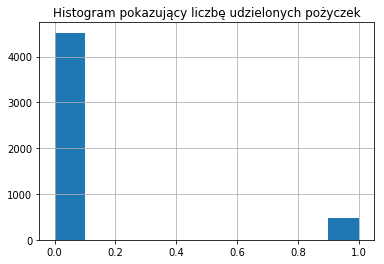

In [19]:
df['Personal Loan'].hist()
plt.title('Histogram pokazujący liczbę udzielonych pożyczek');

Liczbowo te dane prezentują się następująco:

In [22]:
print("Liczba nieprzydzielonych i przydzielonych pożyczek [0 1] - " + str(np.asarray(df.groupby('Personal Loan').Age.count())))

Liczba nieprzydzielonych i przydzielonych pożyczek [0 1] - [4520  480]


Podział zbioru można przedstawić na macierzy wykresów punktowych. Pozwoli to zobaczyć jak dzieli się zbiór w zależności od różnych atrybutów przyjętych jako współrzędne. Uwidoczni to korelację między atrybutami.

C:\Users\matik\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\matik\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


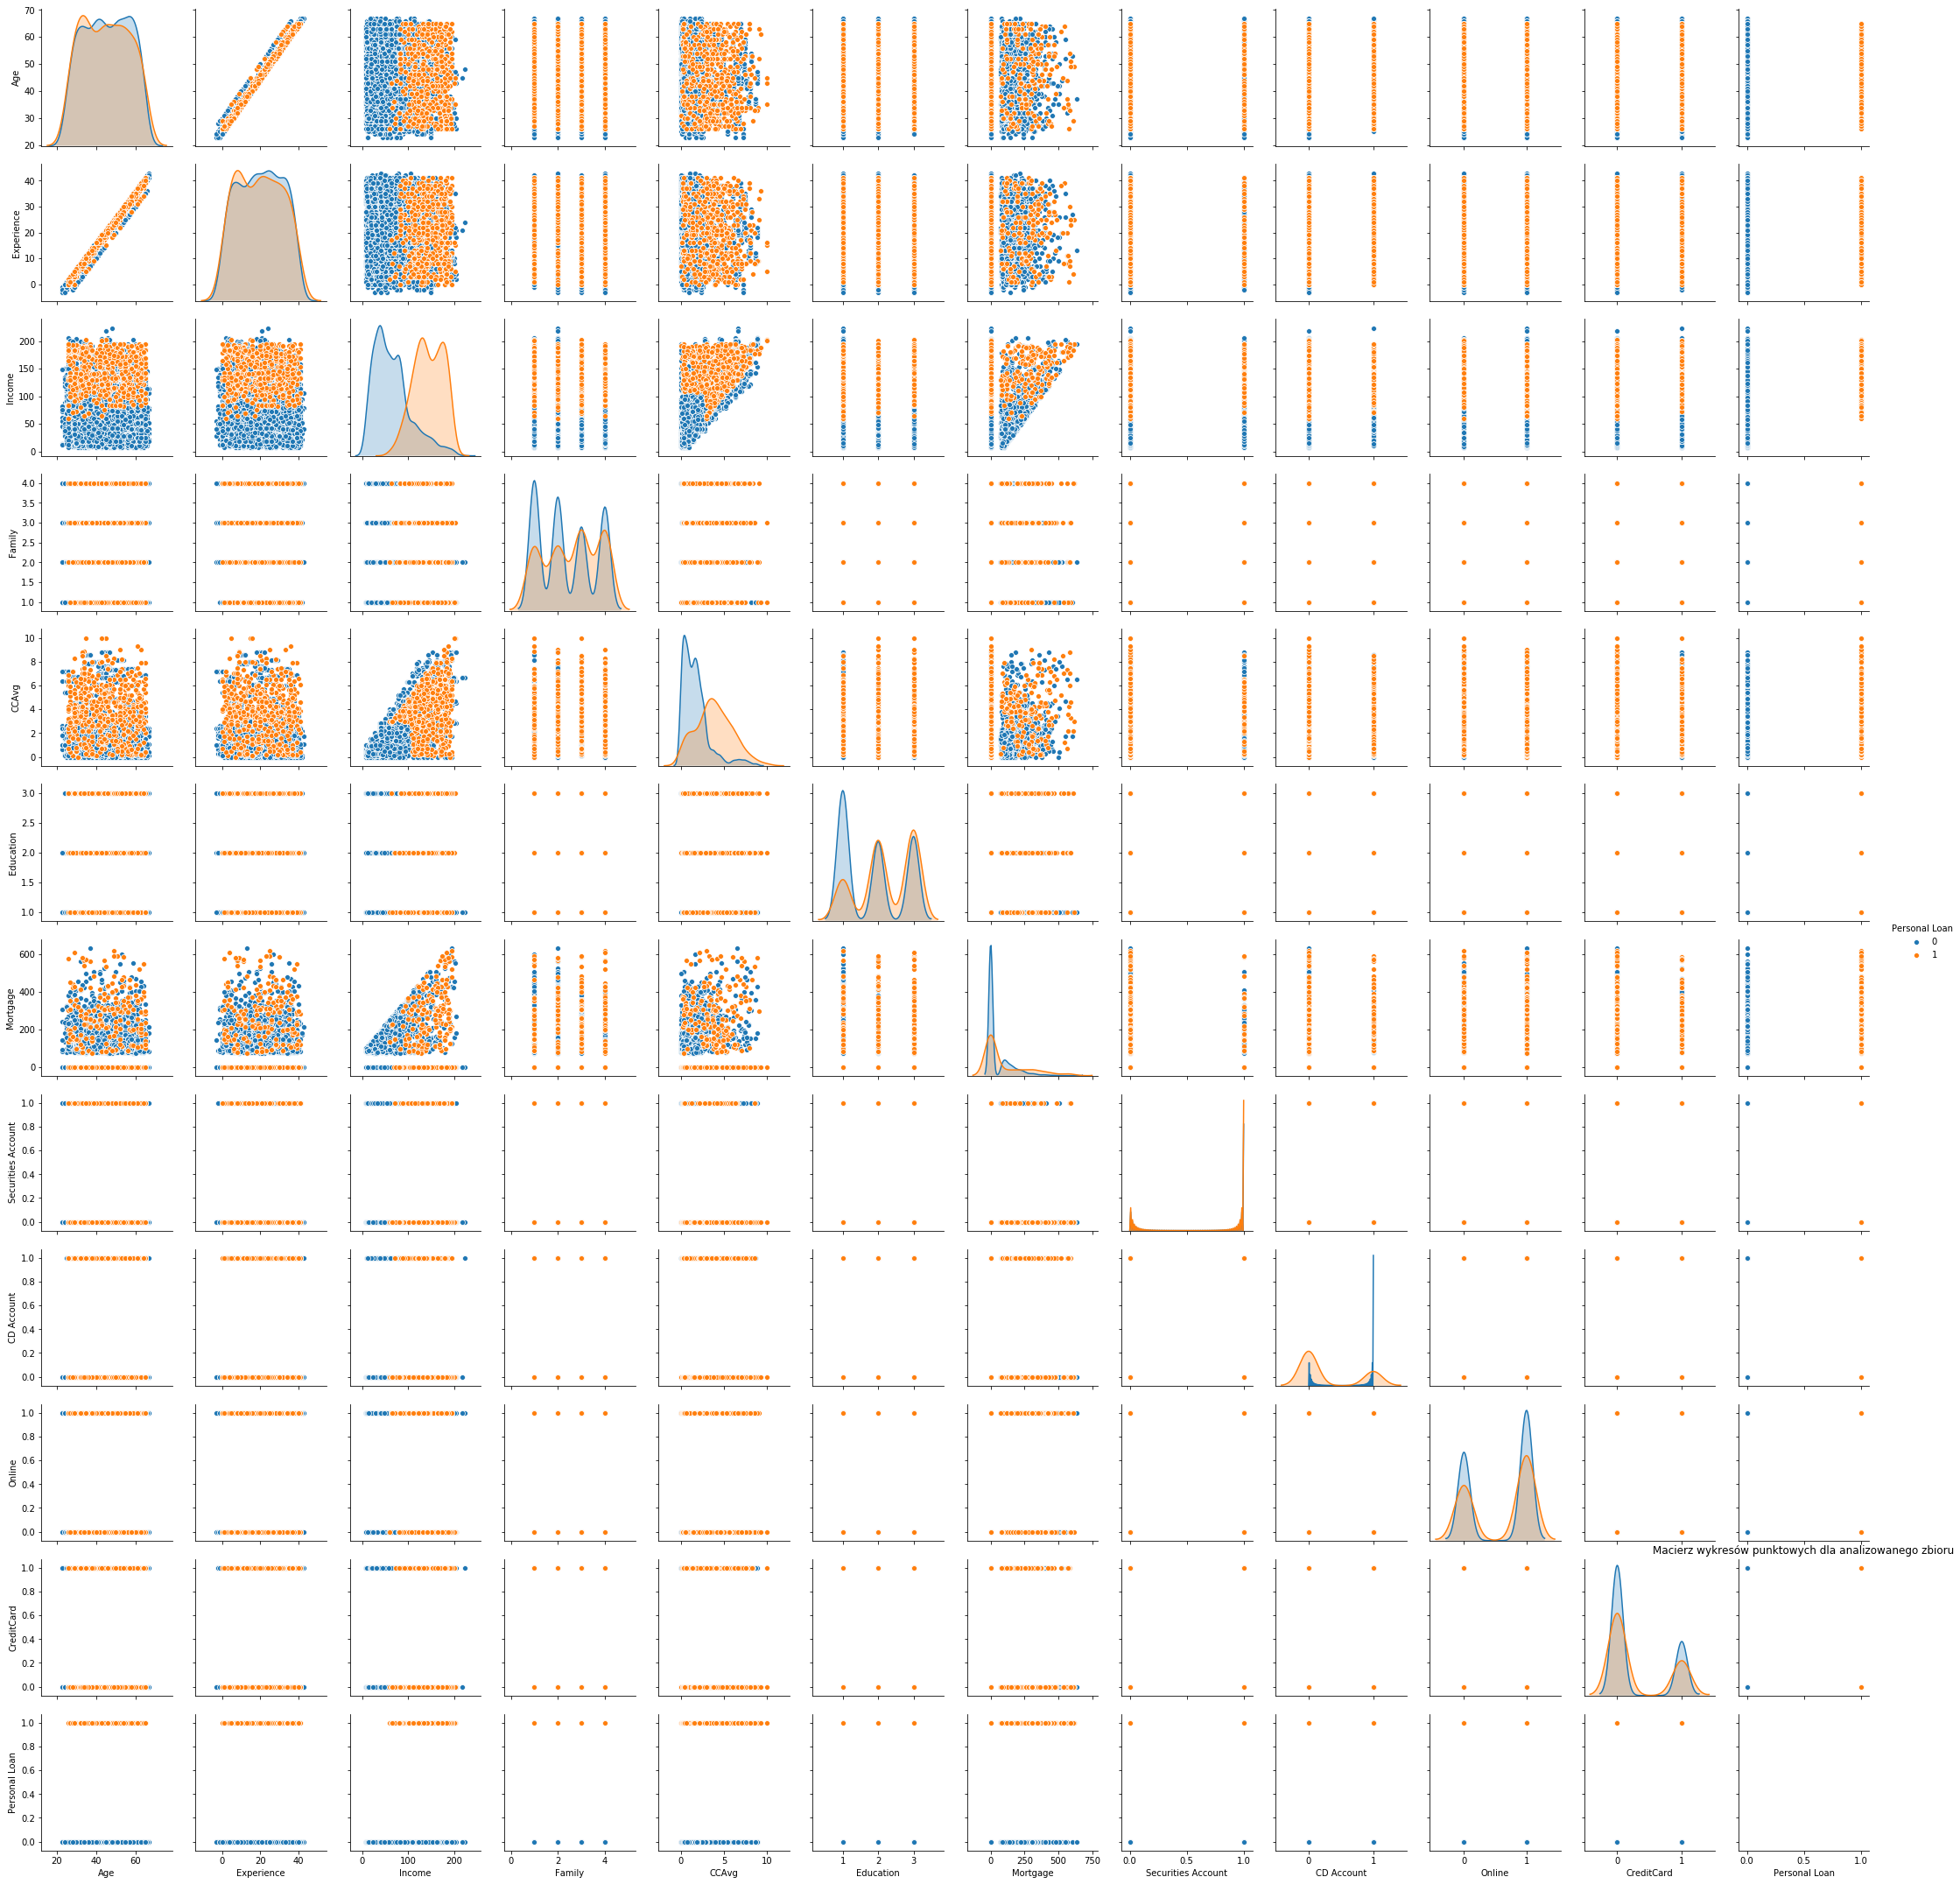

In [23]:
sns.pairplot(df, hue='Personal Loan')
plt.title("Macierz wykresów punktowych dla analizowanego zbioru")
plt.show()

Korelację można dokładniej przedstawić w postaci macierzy korelacji. 

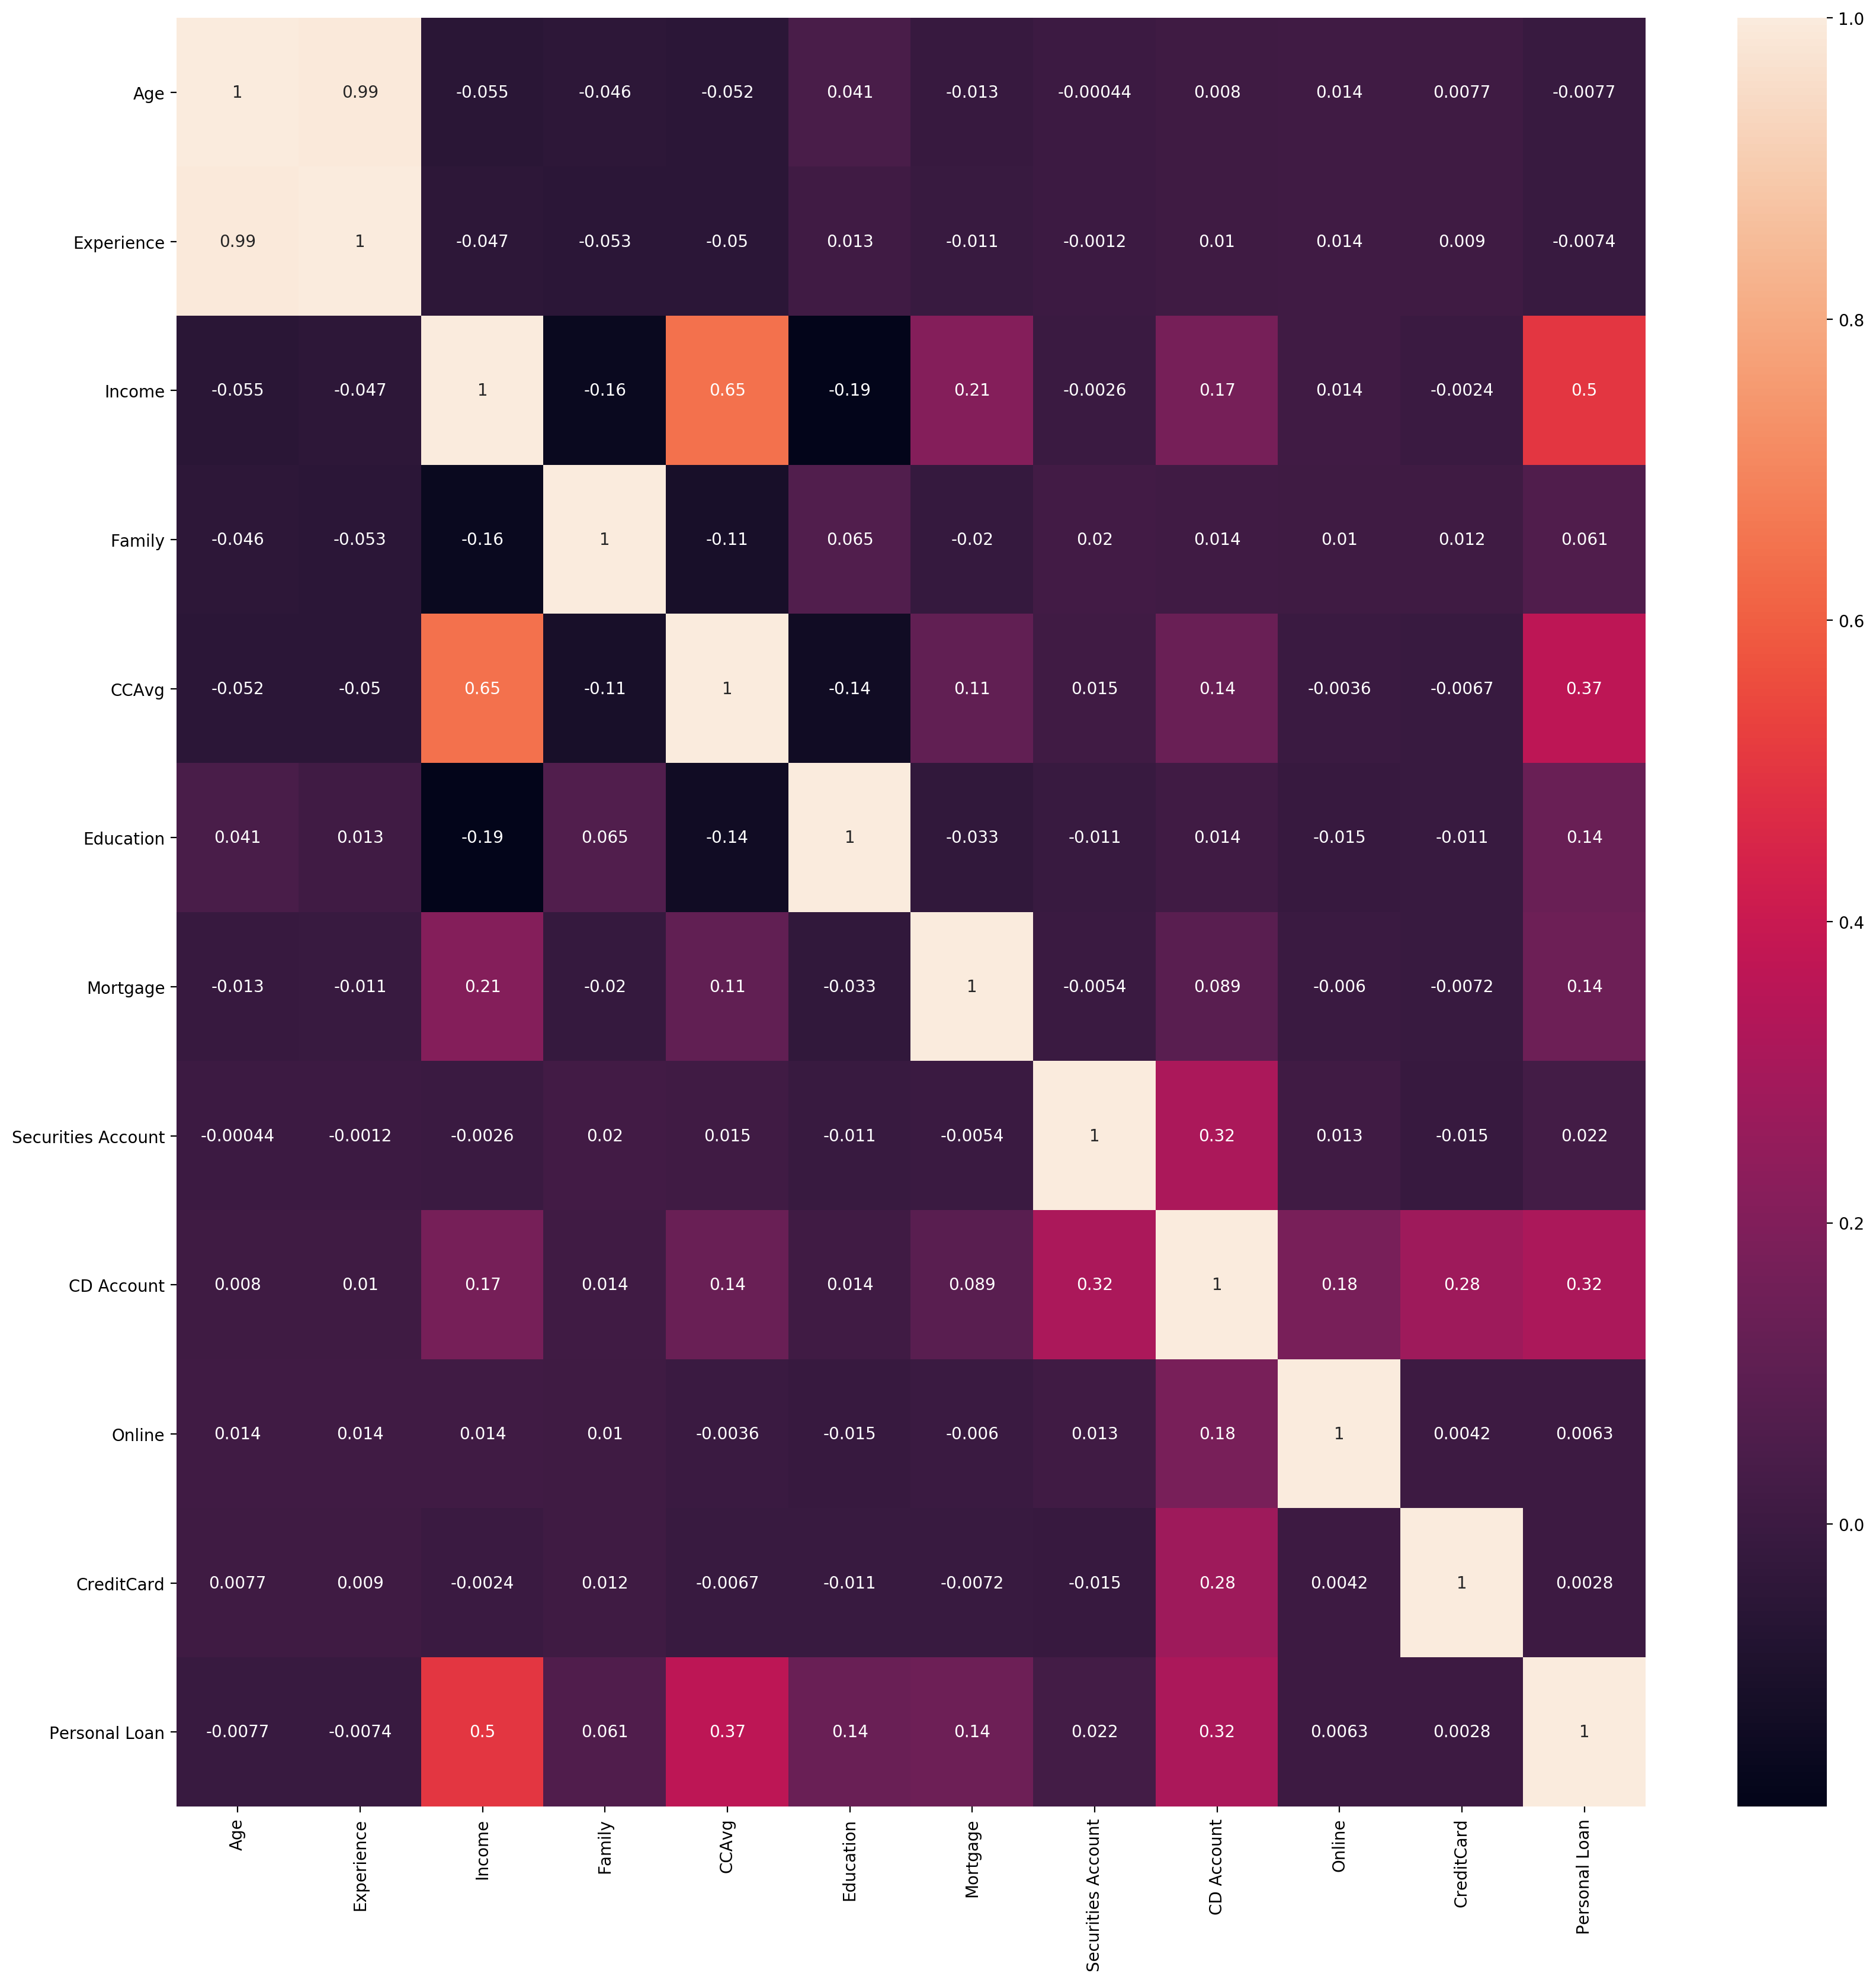

In [24]:
plt.figure(figsize=(20,20), dpi = 200)
sns.heatmap(df.corr(), annot = df.corr())

Z całej macierzy dla analizowanego problemu potrzebujemy tylko wiersz korelacji atrybuto 'Personal Loan' z pozostałymi atrybutami. Prezentuje się on następująco:

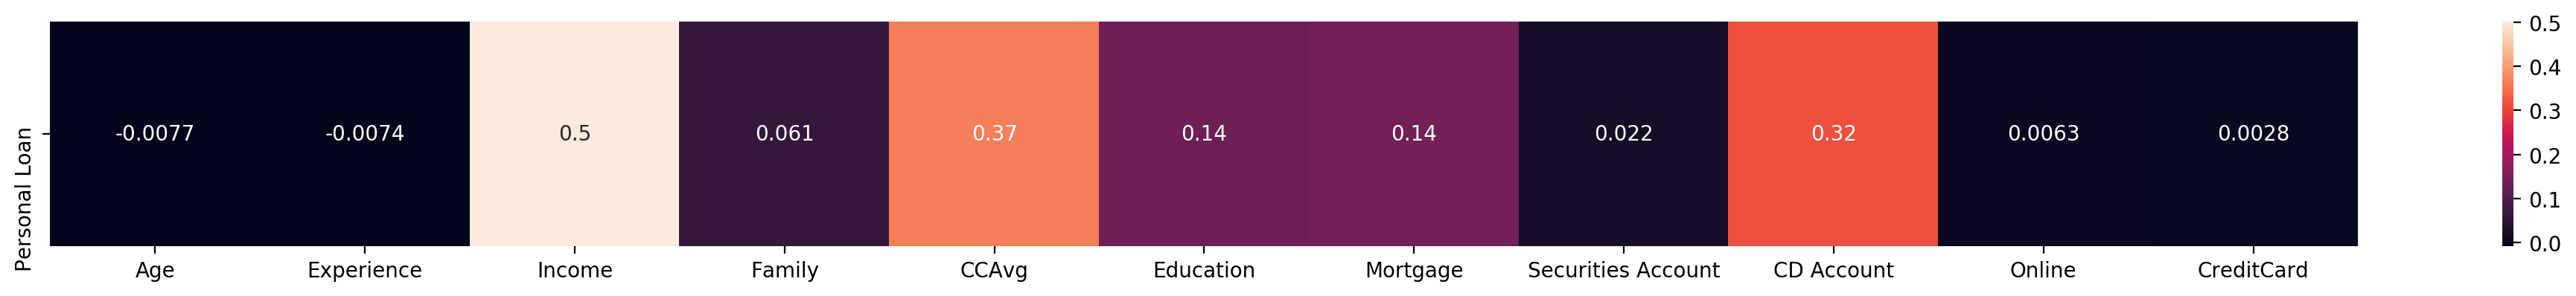

In [27]:
loanCorrelation = df.corr().iloc[11:12 , 0:]

loanCorrelation = loanCorrelation.drop(columns=['Personal Loan'])
plt.figure(figsize = (25, 2), dpi = 200)
sns.heatmap(loanCorrelation, annot = loanCorrelation)

Wartości korelacji poszczególnych atrybutów z atrybutem decyzyjnym można przedstawić w posortowanej tabeli w celu łatwiejszego przeanalizowania które atrybuty mają największy wpływ na pozytywne rozpatrzenie decyzji i przydzieleniu pożyczki. 

In [28]:
sortedLoanCorrelation = loanCorrelation.mean()
sortedLoanCorrelation = sortedLoanCorrelation.sort_values(ascending = False)
sortedLoanCorrelation = pd.DataFrame(sortedLoanCorrelation, columns=['Korelacja atrybutów z przydzieleniem kredytu'])

print(sortedLoanCorrelation)

                    Korelacja atrybutów z przydzieleniem kredytu
Income                                                  0.502462
CCAvg                                                   0.366889
CD Account                                              0.316355
Mortgage                                                0.142095
Education                                               0.136722
Family                                                  0.061367
Securities Account                                      0.021954
Online                                                  0.006278
CreditCard                                              0.002802
Experience                                             -0.007413
Age                                                    -0.007726
